In [2]:
import sys
import os

parent = os.path.dirname(os.path.realpath('../'))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import matplotlib.pyplot as plt
import glob

from core import *
from utils import geometry

from scipy.signal import hilbert

### Analytic solution to wave equation

In [3]:
# P_i       incident pressure distribution
# rho_0     density
# v_not     velocity
# tau       
# t
# omega     angular frequency
# u         = sin(theta)cos(phi) for point Q
# L         aperture length
# w         element width
# Q         point in field
# lam       wavelength
# m         number of runs (?)
# c_0       constant

In [4]:
def fourier_expression(Q, L, f, m, w, c_0):
    assert Q.shape[-1] == 3, "Q must be a 3D vector [x,y,z] or list of 3D vectors (Nx3)"
    Q = Q.astype(np.float128)
    theta = np.arccos(Q[:,2] / np.linalg.norm(Q, axis=-1))
    theta = np.where(np.linalg.norm(Q) == 0, 0, theta)
    phi = np.arctan2(Q[:,1], Q[:,0])
    u = np.sin(theta) * np.cos(phi)
    exp1 = np.sum(np.array([np.sinc((L * f / c_0) * (u - (m_value * c_0 / f) / w)) for m_value in m]), axis=0)
    exp2 = L * w * w * np.sinc(u * w * f / c_0)
    exp3 = np.sqrt((c_0 / (2 * np.pi * np.linalg.norm(Q, axis=-1))))
    return exp1 * exp2 * exp3

def exponential_expression(rho_0, v_0, tau, t, omega_c):
    t = t.astype(np.float128)
    exp1 = rho_0 * v_0 * np.exp(-t / tau) * np.cos(-omega_c * t)
    H = np.heaviside(t, 1)
    return exp1 * H

def convolution(fourier, exponential):
    signals = [np.convolve(exponential, fourier[i,:], mode='same') for i in range(fourier.shape[0])]
    return np.array(signals)

def compute_signal(q, L, F, m, w, c_0, rho_0, v_0, tau, t, omega_c):
    fourier = np.fft.ifft(np.array([fourier_expression(q, L, freq, m, w, c_0) for freq in F]).T, axis=-1)
    exponential = exponential_expression(rho_0, v_0, tau, t, omega_c)
    return convolution(fourier, exponential)

def extract_pressure(signal, timestep, Q):
    distance = np.linalg.norm(Q, axis=-1)
    sigs = [np.abs(np.real(signal[i,(np.round(timestep * distance[i])).astype(np.int32)])) for i in range(len(distance))]
    return np.array(sigs)

def element_summation(resolution, matrix_size, L, f, m, w, t, c_0=1500, rho_0=1000, v_0=1, tau=1, omega_c=1):
    Q = np.meshgrid(np.linspace(-resolution * matrix_size[0] / 2, resolution * matrix_size[0] / 2, matrix_size[0]), 
                    np.linspace(0, 0, 1), 
                    np.linspace(0, resolution * matrix_size[1], matrix_size[1]), 
                    indexing='ij')
    Q = np.stack((Q[0].ravel(), Q[1].ravel(), Q[2].ravel())).T
    
    F = np.linspace(f * 0.95, f * 1.05, 1)
    timestep = (t[-1]-t[0]) / f
    
    sig = compute_signal(Q, L, F, m, w, c_0, rho_0, v_0, tau, t, omega_c)
    
    ps = extract_pressure(sig, timestep, Q)
    
    ps_square = np.array(ps).reshape(matrix_size[0], matrix_size[1])
    new_img = np.zeros_like(ps_square)

    bound = int(L/resolution/2)
    for i in range(-bound,bound+1):
        if i < 0:
            new_img = new_img + np.pad(ps_square, ((0,-i),(0,0)))[-i:]
        elif i > 0:
            new_img = new_img + np.pad(ps_square, ((i,0),(0,0)))[:-i]
        else:
            new_img = new_img + ps_square
    return new_img

In [13]:
image = element_summation(resolution=0.00025, 
                          matrix_size=(256,512), 
                          L=20e-3, 
                          f=1e6, 
                          m=[-2,-1,0,1,2], 
                          w= 10e-3 / 32, 
                          c_0=1500, 
                          rho_0=1000, 
                          v_0=5e-8, 
                          tau=1, 
                          t=np.linspace(0, 20, 200), 
                          omega_c=1)

/tmp/ipykernel_2210156/3539170117.py:9: UserWarning: Casting input data from float128 to float64 for imshow.
  plt.savefig('pressure_field.png', dpi=300)


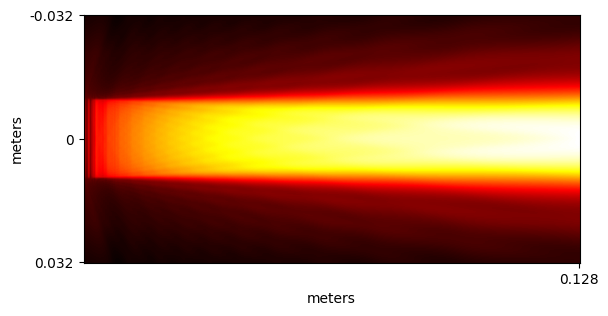

In [19]:
plt.imshow(image, cmap='hot')
plt.xticks([511])
plt.yticks([0,128,255])
plt.gca().set_xticklabels([f'{512*0.00025}'])
plt.gca().set_yticklabels([f'{-128*0.00025}', f'{0}', f'{128*0.00025}'])
plt.xlabel('meters')
plt.ylabel('meters')

plt.savefig('pressure_field.png', dpi=300)

In [ ]:
cmap = plt.get_cmap('viridis')

Q = np.array([np.array([0, 0, i]) for i in np.linspace(0, 0.1, 128)])
sigs = compute_signal(Q, L, F, m, w, c_0, rho_0, v_0, tau, t, omega_c)

plt.xlabel('Time (s e-6)')
plt.ylabel('Pressure (probably Pa)')

for i,signal in enumerate(sigs[::-1]):
    j = 31-i
    j = 0
    plt.plot(t*timestep * 1000000+j*4, signal + j*2e-15, color=cmap(i / len(sigs)), alpha=1, linewidth=0.2)
    
plt.gca().spines[['right', 'top']].set_visible(False)
# plt.savefig('signal.png', pad_inches=0.1 ,dpi=300)